# 🔎 Resume scanner: 🚀 Leverage the power of LLM to improve your resume
### 🚀 Build a Streamlit application powered by Langchain, OpenAI and Google Generative AI

## Table of Contents

1. [Introduction](#intro)<br>
2. [Setup](#setup)<br>
    2.1. [Import](#import)<br>
    2.2. [API keys](#apikeys)<br>
3. [Retrieval](#retrieval)<br>
    3.1. [Upload resume](#uploadResume)<br>
    3.2. [Token Count](#tokenCount)<br>
    3.3. [Embeddings](#embeddings)<br>
    3.4. [Vectorstores](#vectorstores)<br>
    3.5. [Vectorstore-backed retriever](#retriever)<br>
    3.6. [Cohere reranker](#cohere)<br>
4. [Instantiate LLMs](#llm)<br>    
5. [Resume Scanner](#scanner)<br>
    5.1  [Prompt Templates](#prompt_templates)<br>
    5.2. [Invoke LLMs](#invoke_llms)<br>
    5.3. [Contact Information](#contact_info)<br>
    5.4. [Summary](#summary)<br>
    5.5. [Education and Language](#edu_n_language)<br>
    5.6. [Skills and  Certifications](#skills_certifs)<br>
    5.7. [Work experience and Projects](#professional)<br>
    5.8. [Work experience responsibilities and project details](#professional_details)<br>
    5.9. [Improve the work experience section](#improve_workExp)<br>
    5.10. [Improve the projects section](#improve_projects)<br>
    5.11. [Evaluate the Resume](#evaluate_resume)<br>
    5.12. [Putting it all together](#recap)<br>
7. [Streamlit application](#app)<br> 
8. [Concluding](#conclusion)<br> 

# <a class="anchor" id="intro">Introduction</a>

This project aims to build a WEB application in [Streamlit](https://streamlit.io/) that will scan and improve a resume using instruction-tuned Large Language Models (LLMs).

This is how the app should work: The first step is to upload a CV in PDF format. The app will then extract all the information, such as contact details, summary, work experience and skills. It will assess the quality of each section and return a score from 0 to 100. The app will also suggest improvements to make the text more appealing to recruiters.

We will leverage the power of LLMs, specifically Chat GPT from [OpenAI](https://platform.openai.com/overview) and Gemini-pro from [Google](https://ai.google.dev/?hl=en), to extract, assess, and enhance resumes
.
We will use [Langchain](https://python.langchain.com/docs/get_started/introduction), prompt engineering, and retrieval augmented generation techniques to complete these steps.


# <a class="anchor" id="setup">Setup</a>

Before we get started, we need to import the relevant Python libraries and LLM API keys.

## <a class="anchor" id="import">Import libraries</a>

In [ ]:
# !pip install langchain==0.1.4
# !pip install langchain-google-genai==0.0.6
# !pip install langchain-openai==0.0.2.post1
# !pip install langchain-community==0.0.19
# !pip install cohere
# !pip install tiktoken==0.5.2
# !pip install Pillow
# !pip install faiss-cpu
# !pip install python-dotenv
# !pip install markdown
# !pip install pdfminer.six
# !pip install streamlit==1.28.0

In [1]:
# Langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate

from langchain_community.document_loaders import PDFMinerLoader, TextLoader, Docx2txtLoader

from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank
from langchain_community.llms import Cohere

from langchain_openai import OpenAIEmbeddings
from langchain_google_genai import GoogleGenerativeAIEmbeddings

from langchain_community.vectorstores import FAISS

# Other libraries
import datetime, json, os, tiktoken
from IPython.display import Markdown
from dotenv import load_dotenv, find_dotenv
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Feel free to update the assistant language.
ASSISTAN_LANGUAGE = "english"

## <a class="anchor" id="apikeys">API Keys</a>

Our application requires API keys from OpenAI, Google and Cohere.
- **OpenAI** API key: [Get an API key](https://platform.openai.com/account/api-keys)
- **Google** API key: [Get an API key](https://makersuite.google.com/app/apikey)
- **Cohere** API key: [Get an API key](https://dashboard.cohere.com/api-keys)

For security reasons, We will **NOT include** our secret keys in the notebook.

We will store them in a `.env` file and use the [dotenv](https://pypi.org/project/python-dotenv/) library to read them and set them as environment variables.

**Please add your API keys to the `keys.env` file before running the next cell.**

In [3]:
from dotenv import load_dotenv, find_dotenv

try:
    found_dotenv = find_dotenv('keys.env',usecwd=True)
    load_dotenv(found_dotenv)
    
    openai_api_key = os.getenv("api_key_openai")
    google_api_key = os.getenv("api_key_google")
    cohere_api_key = os.getenv("api_key_cohere")

    if (openai_api_key=="Your_API_key") or (google_api_key=="Your_API_key") or (cohere_api_key=="Your_API_key"):
        print("Please add your API keys to the keys.env file")
    
except Exception as e:
    print(f"[ERROR] {e}")

Please add your API keys to the keys.env file


# <a class="anchor" id="retrieval">Retrieval</a>

Before analysing the resume, let's create a Langchain [retrieval](https://python.langchain.com/docs/modules/data_connection/), which includes document loaders to upload the resume, embeddings to create a numerical representation of the text, vector stores to store the embeddings, and retrievers to find the most similar documents to the query.

## <a class="anchor" id="uploadResume">Upload resume</a>

You can upload a resume in PDF format.

We will use [PDFMinerLoader](https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf#using-pdfminer) from Langchain to load and split the resume into an array of documents, where each document contains the page content and the source file as metadata.

For demonstration purposes, we will use a simple data scientist resume generated by ChatGPT. Feel free to upload your CV.

In [4]:
from langchain_community.document_loaders import PDFMinerLoader

def langchain_document_loader(file_path):
    """Load and split a PDF file in Langchain.
    Parameters:
        - file_path (str): path of the file.
    Output:
        - documents: list of Langchain Documents."""

    if file_path.endswith(".pdf"):
        loader = PDFMinerLoader(file_path=file_path)
    else:
        print("You can only upload .pdf files!")

    # 1. Load and split documents
    documents = loader.load_and_split()

    # 2. Update the metadata: add document number to metadata
    for i in range(len(documents)):
        documents[i].metadata = {
            "source": documents[i].metadata["source"],
            "doc_number": i,
        }

    return documents

For longer resumes, it is possible to have multiple documents. In such cases, the relevant information can be found in two consecutive documents.

To ensure that the subsequent document is added to the most relevant retrieved document, we have included the document number in the metadata.

In [5]:
documents = langchain_document_loader("./data/resume/ChatGPT_dataScientist.pdf")
print("number of documents:",len(documents))
documents

number of documents: 1


[Document(page_content='Name Candidate \nAddress AAA \ntest@gmail.com \n123456789 \n\nObjective: \nHighly skilled and experienced data scientist with a track record of success in both Company \nX and Company Y. Proficient in a range of programming languages and tools, with a strong \nability to lead teams and adapt to new challenges. Seeking opportunities to leverage \nexpertise in data science to drive innovation and business growth. \n\nExperience: \nData Scientist - Company Y (2019 - 2024) \n\n-  Led a team of data scientists in developing machine learning models for predictive \n\nanalytics. \n\n-  Utilized TensorFlow and PyTorch for deep learning projects, achieving significant \n\n- \n\nimprovements in model accuracy. \nImplemented Spark and Spark MLlib for big data processing, optimizing performance \nand scalability. \n\n-  Conducted data analysis using Tableau and Plotly, generating actionable insights for \n\nbusiness stakeholders. \n\n-  Collaborated with cross-functional te

## <a class="anchor" id="tokenCount">Token Count</a>

**Token count is the main constraint for our application.**

Although the input token limit is sufficient to process a standard resume (one to two pages) in one call, the output limit is smaller. GPT-3-5 and GPT-4 have an output token limit of 4096 tokens, while Gemini Pro has a limit of only 2048 tokens. For longer resumes, it is not possible to extract all information in one go. We will make multiple calls to LLM and retrieve information section by section (contact information, summary, work experience...).


|  Provider   |  Model | maximum token limit | Output token limit | Price
| -------- | ------- | ------- | ------- | -------
| OpenAI  | [gpt-3.5-turbo-0125](https://platform.openai.com/docs/models/gpt-3-5-turbo)   | 16K | 4096 | Updated pricing can be found on the [OpenAI pricing page](https://openai.com/pricing)
| OpenAI  | [gpt-4-turbo-preview](https://platform.openai.com/docs/models/gpt-4-and-gpt-4-turbo)  | 128K | 4096 | Updated pricing can be found on the [OpenAI pricing page](https://openai.com/pricing)
| Google  | [gemini-pro](https://ai.google.dev/models/gemini?hl=en)    | 32760  | 2048 | Free access to Gemini pro through Google AI Studio with up to **60** requests per minute.

In [6]:
# !pip install --upgrade tiktoken

import tiktoken
def tiktoken_tokens(documents,model="gpt-3.5-turbo-0125"):
    """Use tiktoken (tokeniser for OpenAI models) to return a list of token length per document."""    
    
    encoding = tiktoken.encoding_for_model(model) # returns the encoding used by the model.    
    tokens_length = [len(encoding.encode(doc)) for doc in documents]

    return tokens_length


# Calculate the number of tokens in each document.
documents_length = tiktoken_tokens([doc.page_content for doc in documents],model="gpt-3.5-turbo-0125")

print("Number of tokens per document:",documents_length)
print("Sum of tokens (documents):",sum(documents_length))

Number of tokens per document: [592]
Sum of tokens (documents): 592


>The data scientist resume (generated by Chat GPT) has only 592 tokens. It is possible to extract several sections at once.
>
>However, our application is designed to analyse any CV, so we will extract information section by section to avoid exceeding the output token limit.

##### <a class="anchor" id="embeddings">Embeddings</a>

Embeddings are numerical representations of text data in a high-dimensional vector space. For instance, the size of the embeddings vector size for OpenAI's text-embedding-ada-002 model is 1536.

To identify the most similar documents to a query, we can search for vectors with the highest similarity to the query's embeddings. Cosine similarity is commonly used to measure the similarity between two vectors.s.

We will connect to the following API endpoints for embeddings:

|  Provider   |  Model | Vector dimension | Price
| -------- | ------- | ------- | -------
| OpenAI  | [text-embedding-ada-002](https://platform.openai.com/docs/guides/embeddings/embedding-models)    | 1536 | **$0.00010 / 1K tokens.**
| Google  | [models/embedding-001](https://ai.google.dev/models/gemini?hl=en)    | 768 | **Rate limit:** 1500 requests per minute. used:

In [7]:
def select_embeddings_model(LLM_service="OpenAI"):
    """Connect to the embeddings API endpoint by specifying the name of the embedding model."""
    if LLM_service == "OpenAI":
        embeddings = OpenAIEmbeddings(
            model='text-embedding-ada-002',
            api_key=openai_api_key)

    if LLM_service == "Google":
        embeddings = GoogleGenerativeAIEmbeddings(
            model="models/embedding-001",
            google_api_key=google_api_key
        )
    return embeddings
   
embeddings_OpenAI = select_embeddings_model(LLM_service="OpenAI")
embeddings_google = select_embeddings_model(LLM_service="Google")

## <a class="anchor" id="vectorstores">Vectorstores</a>


A vectorstore is a database used to store embedding vectors. 

There are several open-source options for vector storage. We will use the [Facebook AI Similarity Search (Faiss)](https://python.langchain.com/docs/integrations/vectorstores/faiss) vector database.

In [8]:
from langchain_community.vectorstores import FAISS

def create_vectorstore(embeddings, documents):
    """Create a Faiss vector database."""
    vector_store = FAISS.from_documents(documents=documents, embedding=embeddings)
    
    return vector_store

In [9]:
%%time

vector_store_OpenAI = create_vectorstore(embeddings=embeddings_OpenAI,documents=documents)
vector_store_google = create_vectorstore(embeddings=embeddings_google,documents=documents)

CPU times: total: 62.5 ms
Wall time: 2.25 s


## <a class="anchor" id="retriever">Vectorstore-backed retriever</a>


A [retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/) is responsible for returning relevant documents to a query. 

**Vectorstore-backed retriever** is a simple retriever. It uses semantic search to retrieve documents from a Vectorstore.

In [10]:
def Vectorstore_backed_retriever(vectorstore,search_type="similarity",k=4,score_threshold=None):
    """create a vectorsore-backed retriever
    Parameters: 
        search_type: Defines the type of search that the Retriever should perform.
            Can be "similarity" (default), "mmr", or "similarity_score_threshold"
        k: number of documents to return (Default: 4) 
        score_threshold: Minimum relevance threshold for similarity_score_threshold (default=None)
    """
    search_kwargs={}
    if k is not None:
        search_kwargs['k'] = k
    if score_threshold is not None:
        search_kwargs['score_threshold'] = score_threshold

    retriever = vectorstore.as_retriever(
        search_type=search_type,
        search_kwargs=search_kwargs
    )
    return retriever


base_retriever_OpenAI = Vectorstore_backed_retriever(vector_store_OpenAI,"similarity",k=min(4,len(documents))) 
base_retriever_google = Vectorstore_backed_retriever(vector_store_google,"similarity",k=min(4,len(documents)))

The most similar documents are not necessarily the most relevant.

In the next section, we will create a CohereRerank retriever which will return the most relevant documents.

## <a class="anchor" id="cohere">Cohere reranker</a>

We will wrap our base retriever with a [ContextualCompressionRetriever](https://python.langchain.com/docs/integrations/retrievers/cohere-reranker) and use the [Cohere rerank endpoint](https://docs.cohere.com/docs/reranking) to reorder the results based on semantically **relevance** to the query.

In [11]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank
from langchain_community.llms import Cohere

def CohereRerank_retriever(
    base_retriever, 
    cohere_api_key,cohere_model="rerank-multilingual-v2.0", top_n=2
):
    """Build a ContextualCompressionRetriever using Cohere Rerank endpoint to reorder the results based on relevance.
    Parameters:
       base_retriever: a Vectorstore-backed retriever
       cohere_api_key: the Cohere API key
       cohere_model: The Cohere model can be either 'rerank-english-v2.0' or 'rerank-multilingual-v2.0', with the latter being the default.
       top_n: top n results returned by Cohere rerank, default = 2.
    """
    
    compressor = CohereRerank(
        cohere_api_key=cohere_api_key, 
        model=cohere_model, 
        top_n=top_n
    )

    retriever_Cohere = ContextualCompressionRetriever(
        base_compressor=compressor,
        base_retriever=base_retriever
    )
    
    return retriever_Cohere

In [12]:
retriever_Cohere_google = CohereRerank_retriever(
    base_retriever=base_retriever_google, 
    cohere_api_key=cohere_api_key,
    cohere_model="rerank-multilingual-v2.0",  
    top_n=2
)

retriever_Cohere_openAI = CohereRerank_retriever(
    base_retriever=base_retriever_OpenAI, 
    cohere_api_key=cohere_api_key,
    cohere_model="rerank-multilingual-v2.0",  
    top_n=2
)

In [13]:
query = "Extract the job title and company name of the first work experience."

most_relevant_docs = retriever_Cohere_google.get_relevant_documents(query)

for i in range(len(most_relevant_docs)):
    print(f"""Most similar doc id : {most_relevant_docs[i].metadata['doc_number']} """)


Most similar doc id : 0 


# <a class="anchor" id="llm">Instantiate LLMs</a>

Our appliaction will interact with LLMs, such as GPT3.5-turbo and Google gemini-pro.

We will use the OpenAI and Google APIs, and leverage the `ChatOpenAI` and `ChatGoogleGenerativeAI` Langchain classes to instantiate the following instruction-tuned models:
- **OpenAI API**: [gpt-3.5-turbo-0125](https://platform.openai.com/docs/models/gpt-3-5-turbo) and [gpt-4-turbo-preview](https://platform.openai.com/docs/models/gpt-4-and-gpt-4-turbo). \
These models are paid and prices are per 1,000 tokens (~750 words). Updated pricing can be found on the [OpenAI pricing page](https://openai.com/pricing).
- **Google Gemini API**: [gemini-pro](https://ai.google.dev/models/gemini?hl=en). \
Free access to Gemini pro through Google AI Studio with up to 60 requests per minute.


|  Provider   |  Model | maximum token limit | Output token limit | Price
| -------- | ------- | ------- | ------- | -------
| OpenAI  | [gpt-3.5-turbo-0125](https://platform.openai.com/docs/models/gpt-3-5-turbo)   | 16K | 4096 | Updated pricing can be found on the [OpenAI pricing page](https://openai.com/pricing)
| OpenAI  | [gpt-4-turbo-preview](https://platform.openai.com/docs/models/gpt-4-and-gpt-4-turbo)  | 128K | 4096 | Updated pricing can be found on the [OpenAI pricing page](https://openai.com/pricing)
| Google  | [gemini-pro](https://ai.google.dev/models/gemini?hl=en)    | 32760  | 2048 | Free access to Gemini pro through Google AI Studio with up to **60** requests per minute.

The main parameters for all of these LLMs are:
- **temperature:** controls the degree of randomness in token selection. Higher values increase diversity, and hence, creativity.
- **top_k:** Selects the next token from the most probable **k** tokens by using temperature. Lower k focuses on more probable tokens. 
- **top_p:** The cumulative probability cutoff for token selection. Higher values increase diversity.

Let's create a function to instantiate a chat model.

In [14]:
def instantiate_LLM(LLM_provider,api_key,temperature=0.5,top_p=0.95,model_name=None):
    """Instantiate LLM in Langchain.
    Parameters:
        LLM_provider (str): the LLM provider; in ["OpenAI","Google","HuggingFace"]
        model_name (str): in ["gpt-3.5-turbo", "gpt-3.5-turbo-0125", "gpt-4-turbo-preview", 
            "gemini-pro", "mistralai/Mistral-7B-Instruct-v0.2"].            
        api_key (str): google_api_key or openai_api_key or huggingfacehub_api_token 
        temperature (float): Range: 0.0 - 1.0; default = 0.5
        top_p (float): : Range: 0.0 - 1.0; default = 1.
    """
    if LLM_provider == "OpenAI":
        llm = ChatOpenAI(
            api_key=api_key,
            model=model_name,
            temperature=temperature,
            model_kwargs={
                "top_p": top_p
            }
        )
    if LLM_provider == "Google":
        llm = ChatGoogleGenerativeAI(
            google_api_key=api_key,
            # model="gemini-pro",
            model=model_name,
            temperature=temperature,
            top_p=top_p,
            convert_system_message_to_human=True
        )
    return llm


In [15]:
def set_LLM_and_retriever(provider="OpenAI",model_name="gpt-3.5-turbo-0125",temperature=0.0,top_p=0.95):
    if provider=="OpenAI":
        llm = instantiate_LLM(
            "OpenAI",
            api_key=openai_api_key,
            temperature=temperature,
            top_p=top_p,
            model_name=model_name
        )
        retriever = retriever_Cohere_openAI
    else: # "Google"
        llm = instantiate_LLM(
            LLM_provider="Google",
            api_key=google_api_key,
            temperature=temperature,
            top_p=top_p, 
            model_name="gemini-pro"
        )
        retriever = retriever_Cohere_google
        
    return llm,retriever 

In [16]:
llm,retriever = set_LLM_and_retriever(provider="Google",temperature=0.0)

# <a class="anchor" id="scanner">Resume Scanner</a>

In the following sections, we will call the LLM to:
- Extract information from the resume (such as contact information, skills, work experience...). 
- Evaluate the quality of each section and bullet point and return a score on a scale from 0 to 100. 
- Improve the text and make it more appealing to recruiters. 

## <a class="anchor" id="prompt_templates">Prompt Templates</a>

We will use the `PromptTemplate` class from Langchain to generate prompts for the LLM.

The PromptTemplate will be generated using the following `templates`.

In [17]:
#####################################################
#                 Prompt Templates
#####################################################

templates = {}

# 2.1 Contact information Section
templates[
    "Contact__information"
] = """Extract and evaluate the contact information. \
Output a dictionary with the following keys:
- candidate__name 
- candidate__title
- candidate__location
- candidate__email
- candidate__phone
- candidate__social_media: Extract a list of all social media profiles, blogs or websites.
- evaluation__ContactInfo: Evaluate in {language} the contact information.
- score__ContactInfo: Rate the contact information by giving a score (integer) from 0 to 100.
"""

# 2.2. Summary Section
templates[
    "CV__summary"
] = """Extract the summary and/or objective section. This is a separate section of the resume. \
If the resume doed not contain a summary and/or objective section, then simply write "unknown"."""

# 2.3. WORK Experience Section

templates[
    "Work__experience"
] = """Extract all work experiences. For each work experience: 
1. Extract the job title.
2. Extract the company.  
3. Extract the start date and output it in the following format: \
YYYY/MM/DD or YYYY/MM or YYYY (depending on the availability of the day and month).
4. Extract the end date and output it in the following format: \
YYYY/MM/DD or YYYY/MM or YYYY (depending on the availability of the day and month).
5. Output a dictionary with the following keys: job__title, job__company, job__start_date, job__end_date.

Format your response as a list of dictionaries.
"""

# 2.4. Projects Section
templates[
    "CV__Projects"
] = """Include any side projects outside the work experience. 
For each project:
1. Extract the title of the project. 
2. Extract the start date and output it in the following format: \
YYYY/MM/DD or YYYY/MM or YYYY (depending on the availability of the day and month).
3. Extract the end date and output it in the following format: \
YYYY/MM/DD or YYYY/MM or YYYY (depending on the availability of the day and month).
4. Output a dictionary with the following keys: project__title, project__start_date, project__end_date.

Format your response as a list of dictionaries.
"""

# 2.5. Education Section
templates[
    "CV__Education"
] = """Extract all educational background and academic achievements.
For each education achievement:
1. Extract the name of the college or the high school. 
2. Extract the earned degree. Honors and achievements are included.
3. Extract the start date and output it in the following format: \
YYYY/MM/DD or YYYY/MM or YYYY (depending on the availability of the day and month).
4. Extract the end date and output it in the following format: \
YYYY/MM/DD or YYYY/MM or YYYY (depending on the availability of the day and month).
5. Output a dictionary with the following keys: edu__college, edu__degree, edu__start_date, edu__end_date.

Format your response as a list of dictionaries.
"""

templates[
    "Education__evaluation"
] = """Your task is to perform the following actions:  
1. Rate the quality of the Education section by giving an integer score from 0 to 100. 
2. Evaluate (in three sentences and in {language}) the quality of the Education section.
3. Output a dictionary with the following keys: score__edu, evaluation__edu.
"""

# 2.6. Skills
templates[
    "candidate__skills"
] = """Extract the list of soft and hard skills from the skill section. Output a list.
The skill section is a separate section.
"""

templates[
    "Skills__evaluation"
] = """Your task is to perform the following actions: 
1. Rate the quality of the Skills section by giving an integer score from 0 to 100.
2. Evaluate (in three sentences and in {language}) the quality of the Skills section.
3. Output a dictionary with the following keys: score__skills, evaluation__skills.
"""

# 2.7. Languages
templates[
    "CV__Languages"
] = """Extract all the languages that the candidate can speak. For each language:
1. Extract the language.
2. Extract the fluency. If the fluency is not available, then simply write "unknown".
3. Output a dictionary with the following keys: spoken__language, language__fluency.

Format your response as a list of dictionaries.
"""

templates[
    "Languages__evaluation"
] = """ Your task is to perform the following actions: 
1. Rate the quality of the language section by giving an integer score from 0 to 100.
2. Evaluate (in three sentences and in {language}) the quality of the language section.
3. Output a dictionary with the following keys: score__language,evaluation__language.
"""

# 2.8. Certifications
templates[
    "CV__Certifications"
] = """Extraction of all certificates other than education background and academic achievements. \
For each certificate: 
1. Extract the title of the certification. 
2. Extract the name of the organization or institution that issues the certification.
3. Extract the date of certification and output it in the following format: \
YYYY/MM/DD or YYYY/MM or YYYY (depending on the availability of the day and month).
4. Extract the certification expiry date and output it in the following format: \
YYYY/MM/DD or YYYY/MM or YYYY (depending on the availability of the day and month).
5. Extract any other information listed about the certification. if not found, then simply write "unknown".
6. Output a dictionary with the following keys: certif__title, certif__organization, certif__date, certif__expiry_date, certif__details.

Format your response as a list of dictionaries.
"""

templates[
    "Certif__evaluation"
] = """Your task is to perform the following actions: 
1. Rate the certifications by giving an integer score from 0 to 100.
2. Evaluate (in three sentences and in {language}) the certifications and the quality of the text.
3. Format your response as a dictionary with the following keys: score__certif,evaluation__certif.
"""


# 3. PROMPTS

PROMPT_IMPROVE_SUMMARY = """Your are given a resume (delimited by <resume></resume>) \
and a summary (delimited by <summary></summary>).
1. In {language}, evaluate the summary (format and content) .
2. Rate the summary by giving an integer score from 0 to 100. \
If the summary is "unknown", the score is 0.
3. In {language}, strengthen the summary. The summary should not exceed 5 sentences. \
If the summary is "unknown", generate a strong summary in {language} with no more than 5 sentences. \
Please include: years of experience, top skills and experiences, some of the biggest achievements, and finally an attractive objective.
4. Format your response as a dictionary with the following keys: evaluation__summary, score__summary, CV__summary_enhanced.

<summary>
{summary}
</summary>
------
<resume>
{resume}
</resume>
"""

PROMPT_IMPROVE_WORK_EXPERIENCE = """you are given a work experience text delimited by triple backticks.
1. Rate the quality of the work experience text by giving an integer score from 0 to 100. 
2. Suggest in {language} how to make the work experience text better and stronger.
3. Strengthen the work experience text to make it more appealing to a recruiter in {language}. \
Provide additional details on responsibilities and quantify results for each bullet point. \
Format your text as a string in {language}.
4. Format your response as a dictionary with the following keys: "Score__WorkExperience", "Comments__WorkExperience" and "Improvement__WorkExperience".

Work experience text: ```{text}```
"""

PROMPT_IMPROVE_PROJECT = """you are given a project text delimited by triple backticks.
1. Rate the quality of the project text by giving an integer score from 0 to 100. 
2. Suggest in {language} how to make the project text better and stronger.
3. Strengthen the project text to make it more appealing to a recruiter in {language}, \
including the problem, the approach taken, the tools used and quantifiable results. \
Format your text as a string in {language}.
4. Format your response as a dictionary with the following keys: Score__project, Comments__project, Improvement__project.

project text: ```{text}```
"""

PROMPT_EVALUATE_RESUME = """You are given a resume delimited by triple backticks. 
1. Provide an overview of the resume in {language}.
2. Provide a comprehensive analysis of the three main strengths of the resume in {language}. \
Format the top 3 strengths as string containg three bullet points.
3. Provide a comprehensive analysis of the three main weaknesses of the resume in {language}. \
Format the top 3 weaknesses as string containg three bullet points.
4. Format your response as a dictionary with the following keys: resume_cv_overview, top_3_strengths, top_3_weaknesses.

The strengths and weaknesses lie in the format, style and content of the resume.

Resume: ```{text}```
"""

>As you can see, we have provided **clear and specific instructions** to guide the model towards the desired output. To obtain relevant results, we have also:
>- **Used delimiters** (such as triple backticks) for clear indication of context.
>- **Formatted the output** as a JSON structured object. We will use the `json.loads` command. If it fails, parsing the formatted output will be straightforward.
>- **Specified the steps** for completing a task. For example, to evaluate the skills section, we asked the model to first evaluate this section in three sentences, then rate its quality by giving an integer score from 0 to 100, and finally output a Json dictionary.
>
>**It is evident that LLM can perform various tasks in a single call. For instance, our inference tasks involve extracting information such as skills and academic achievements, evaluating the text's quality, and rating it on a scale of 0 to 100. LLMs are powerful as they can provide relevant answers for multiple tasks with just one direct prompt, without any examples (i.e. zero-shot), unlike traditional machine learning workflows that require a separate model for each task.**

Now, let's create a function to create the PromptTemplate from the templates.

In [18]:
def create_prompt_template(resume_sections, language=ASSISTAN_LANGUAGE):
    """Create the promptTemplate for selected resume sections.
    Parameters:
       resume_sections (list): List of resume sections from which information will be extracted.
       language (str): the language of the AI assistant.
    """

    # Create the final template: Add the templates from the 'templates' dictionary where keys = resume_sections
    template = f"""For the following resume delimited by triple backticks, output in {language} the following information:\n\n"""

    for key in resume_sections:
        template += key + ": " + templates[key] + "\n---------\n\n"

    template += "For any requested information, if it is not found, output 'unknown'.\n\n"
    template += (
        """Format the final output as a json dictionary with the following keys: ("""
    )

    for key in resume_sections:
        template += "" + key + ", "
    template = template[:-2] + ")"  # remove the last ", "

    template += """\n\nResume: ```{text}```"""

    # Create the PromptTemplate
    prompt_template = PromptTemplate.from_template(template)

    return prompt_template

The final template includes a placeholder for the context (i.e. retrieved documents) and the assistant language. It instructs the LLM to answer the question based solely on the provided context. The `PromptTemplate` uses this template to return a LLM prompt.

In [19]:
# Here is a example:

prompt_template = create_prompt_template(
    ['Contact__information','CV__summary','Work__experience'],
    language=ASSISTAN_LANGUAGE
)

print("**Number of tokens** in the prompt_template (instructions with no context):",sum(tiktoken_tokens([prompt_template.template])),"tokens.")

print("\n**LLM prompt example:**\n")
# Format the PromptTemplate
prompt = prompt_template.format_prompt(text="...",language=ASSISTAN_LANGUAGE).text

print(prompt)

**Number of tokens** in the prompt_template (instructions with no context): 343 tokens.

**LLM prompt example:**

For the following resume delimited by triple backticks, output in english the following information:

Contact__information: Extract and evaluate the contact information. Output a dictionary with the following keys:
- candidate__name 
- candidate__title
- candidate__location
- candidate__email
- candidate__phone
- candidate__social_media: Extract a list of all social media profiles, blogs or websites.
- evaluation__ContactInfo: Evaluate in english the contact information.
- score__ContactInfo: Rate the contact information by giving a score (integer) from 0 to 100.

---------

CV__summary: Extract the summary and/or objective section. This is a separate section of the resume. If the resume doed not contain a summary and/or objective section, then simply write "unknown".
---------

Work__experience: Extract all work experiences. For each work experience: 
1. Extract the job ti

## <a class="anchor" id="invoke_llms">Invoke LLMs</a>

Here, we create a function to invoke the LLM and get the content of its response.

In [20]:
def invoke_LLM(
    llm,
    documents,
    resume_sections: list,
    info_message="",
    language=ASSISTAN_LANGUAGE,
):
    """Invoke LLM and get a response.
    Parameters:
     - llm: the LLM to call
     - documents: the Langchain Documents. 
     - resume_sections (list): List of resume sections to be parsed.
     - info_message (str): display an informational message.
     - language (str): the assistant language. 

     Output:
     - response_content (str): the content of the LLM response.
     - response_tokens_count (int): count of response tokens.
    """

    now = (datetime.datetime.now()).strftime("%H:%M:%S")
    print(f"**{now}** \t{info_message}")  

    # 1. Create the promptTemplate.
    prompt_template = create_prompt_template(
        resume_sections,
        language=language,
    )

    # 2. Format the PromptTemplate 
    if language is not None:
        prompt = prompt_template.format_prompt(text=documents, language=language).text
    else:
        prompt = prompt_template.format_prompt(text=documents).text

    # 3. Invoke the LLM
    response = llm.invoke(prompt)
    
    response_content = response.content[
        response.content.find("{") : response.content.rfind("}") + 1
    ]
    response_tokens_count = sum(tiktoken_tokens([response_content]))
    print(f"""response tokens: {response_tokens_count}""")

    return response_content, response_tokens_count

## <a class="anchor" id="contact_info">Contact Information</a>

Name, Title, Location, Email, Phone number and Social media profiles will be extracted.

In [21]:
%%time

##########################################################################################################
#     CONTACT_INFORMATION: Name, Title, Location, Email, Phone number and Social media profiles.
##########################################################################################################

try:
    response_content, response_tokens_count = invoke_LLM(
        llm,
        documents,
        resume_sections=["Contact__information"],
        info_message="Extract and evaluate contact information...",
        language=ASSISTAN_LANGUAGE,
    )
    
    try:
        # Load response_content into json dictionary
        CONTACT_INFORMATION = json.loads(response_content, strict=False)
    except Exception as e:
        print("[ERROR] json.loads returns error:", e)
        CONTACT_INFORMATION = {}
        
except Exception as error:
    print("[ERROR]:", error)
    CONTACT_INFORMATION = {}
    
CONTACT_INFORMATION 

**17:24:15** 	Extract and evaluate contact information...
response tokens: 127
CPU times: total: 0 ns
Wall time: 4.95 s


{'Contact__information': {'candidate__name': 'Name Candidate',
  'candidate__title': 'Data Scientist',
  'candidate__location': 'unknown',
  'candidate__email': 'test@gmail.com',
  'candidate__phone': '123456789',
  'candidate__social_media': [],
  'evaluation__ContactInfo': "The contact information provided is complete and easy to find. It includes the candidate's name, title, email, and phone number. However, it does not include any social media profiles or website.",
  'score__ContactInfo': 80}}

**We will create a function to parse the response if json.loads fails.**

In [22]:
def extract_from_text(text,start_tag,end_tag=None):
    """Use start and end tags to extract a substring from text."""
    start_index = text.find(start_tag)
    if end_tag is None:
        extacted_txt = text[start_index+len(start_tag):]
    else:
        end_index = text.find(end_tag) 
        extacted_txt = text[start_index+len(start_tag):end_index]
    
    return extacted_txt

In [23]:
try:
    CONTACT_INFORMATION = json.loads(response_content+"}", strict=False) # Add "}" for error simulation
except Exception as e:
    print("[ERROR] json.loads returns error:",e)

    # Parse the response_content
    print("\n['INFO'] Parse response content...\n")
    name = extract_from_text(response_content,"\"candidate__name\": ","\"candidate__title\":")  
    role = extract_from_text(response_content,"\"candidate__title\": ","\"candidate__location\":")
    address = extract_from_text(response_content,"\"candidate__location\": ","\"candidate__email\":") 
    email_address = extract_from_text(response_content,"\"candidate__email\": ","\"candidate__phone\":")
    phone_number = extract_from_text(response_content,"\"candidate__phone\": ","\"candidate__social_media\":")
    social_media = extract_from_text(response_content,"\"candidate__social_media\": ","\"evaluation__ContactInfo\":")
    eval__ContactInfo = extract_from_text(response_content,"\"evaluation__ContactInfo\": ","\"score__ContactInfo\":")
    score__ContactInfo= extract_from_text(response_content,"\"score__ContactInfo\": ",None)

    # Create the dictionary
    CONTACT_INFORMATION = {}

    CONTACT_INFORMATION['Contact__information'] = {
        'candidate__name': name[:name.rfind(",\n")].strip()[1:-1],
        'candidate__title': role[:role.rfind(",\n")].strip()[1:-1],
        'candidate__location': address[:address.rfind(",\n")].strip()[1:-1],
        'candidate__email': email_address[:email_address.rfind(",\n")].strip()[1:-1],
        'candidate__phone': phone_number[:phone_number.rfind(",\n")].strip()[1:-1],
        'candidate__social_media': social_media[0:social_media.rfind("}\n")-1][1:-1].strip(),
        'evaluation__ContactInfo': eval__ContactInfo[0:eval__ContactInfo.rfind("}\n")-1][1:-1].strip(),
        'score__ContactInfo': score__ContactInfo[0:score__ContactInfo.rfind("}\n")-1].strip()
        
    } 
    # Convert score to int
    try:
        CONTACT_INFORMATION["Contact__information"]["score__ContactInfo"] = int(
            CONTACT_INFORMATION["Contact__information"]["score__ContactInfo"]
        )
    except:
        CONTACT_INFORMATION["Contact__information"]["score__ContactInfo"] = -1

CONTACT_INFORMATION

[ERROR] json.loads returns error: Extra data: line 12 column 2 (char 529)

['INFO'] Parse response content...



{'Contact__information': {'candidate__name': 'Name Candidate',
  'candidate__title': 'Data Scientist',
  'candidate__location': 'unknown',
  'candidate__email': 'test@gmail.com',
  'candidate__phone': '123456789',
  'candidate__social_media': '],',
  'evaluation__ContactInfo': 'The contact information provided is complete and easy to find. It includes the candidate\'s name, title, email, and phone number. However, it does not include any social media profiles or website.",',
  'score__ContactInfo': 80}}

**Let's create a function for parsing any response_content.**

In [24]:
def ResponseContent_Parser(response_content,list_fields,list_rfind,list_exclude_first_car ):
    """This is a function to parse any response_content.
    Parameters:
     - response_content (str): the LLM response's content.
     - list_fields (list): List of fields to parse.
            A field can be a dictionary. The key of the dictionary will not be parsed.
            Example: [{'Contact__information':['candidate__name','candidate__title','candidate__location']},
                     'CV__summary']
            The 'Contact__Information' field content will not be parsed in this example.
     - list_rfind (list): To parse the content of a field, we first extract the text between this field and \
            the next field. Then, extract the text using the Python `rfind` command, which returns the highest index in the text \
            where the substring is found.
     - list_exclude_first_car (list): Exclusion or not of the first and last characters (i.e. remove \")
    
    Output:
      - INFORMATION_dict: A dictionary, where fields are the keys and the extracted texts are the values.
     
     """
    # 1. Format the list_fields as a list of tuples. 
    # Each tuple should contain the field, whether to extract information or not, and the key of the dictionary.
    list_fields_formatted = [] 
    
    for field in list_fields:    
        if type(field) is dict:
            # The key of the dictionary will not be parsed.
            list_fields_formatted.append((list(field.keys())[0],False,None)) 
            for val in list(field.values())[0]:
                list_fields_formatted.append((val,True,list(field.keys())[0]))
        else:
            list_fields_formatted.append((field,True,None))
            
    list_fields_formatted.append((None,False,None))
    
    # 2. Parse the response_content
    Parsed_content = {}
    
    for i in range(len(list_fields_formatted)-1):  
        if list_fields_formatted[i][1] is False: 
            Parsed_content[list_fields_formatted[i][0]] = {} # Initialize the dictionary
        if list_fields_formatted[i][1]:
            # 2.1. Extract the text between this field and the next one
            extracted_value = extract_from_text(
                response_content,
                f"\"{list_fields_formatted[i][0]}\": ",
                f"\"{list_fields_formatted[i+1][0]}\":"
            ) 
            
            # 2.2. Extract the text using the Python `rfind` command, which returns the highest index in the text where the substring is found.
            if list_rfind[i] is not None:
                extracted_value = extracted_value[:extracted_value.rfind(list_rfind[i])].strip()
                
            # 2.3. Remove the first and last characters (i.e. remove \")
            if list_exclude_first_car[i]:
                extracted_value = extracted_value[1:-1].strip()

            # 2.4. Update the dictionary Parsed_content.
            if list_fields_formatted[i][2] is None:
                Parsed_content[list_fields_formatted[i][0]] = extracted_value
            else:
                Parsed_content[list_fields_formatted[i][2]][list_fields_formatted[i][0]] = extracted_value
 
    return Parsed_content

In [25]:
# List of keys. A field can be a dictionary. The key of the dict will not be parsed.
list_fields = [{'Contact__information':['candidate__name','candidate__title','candidate__location',
                                        'candidate__email','candidate__phone','candidate__social_media',
                                        'evaluation__ContactInfo','score__ContactInfo']}]
# list of rfind
list_rfind = [",\n",",\n",",\n",",\n",",\n",",\n",",\n",",\n","}\n"]

# Exclude last and first car:
list_exclude_first_car = [True,True,True,True,True,True,False,True,False]

# Parse response content
CONTACT_INFORMATION = ResponseContent_Parser(response_content,list_fields,list_rfind,list_exclude_first_car)

# Convert score to int
try:
    CONTACT_INFORMATION["Contact__information"]["score__ContactInfo"] = int(
        CONTACT_INFORMATION["Contact__information"]["score__ContactInfo"]
    )
except:
    CONTACT_INFORMATION["Contact__information"]["score__ContactInfo"] = -1

CONTACT_INFORMATION

{'Contact__information': {'candidate__name': 'Name Candidate',
  'candidate__title': 'Data Scientist',
  'candidate__location': 'unknown',
  'candidate__email': 'test@gmail.com',
  'candidate__phone': '123456789',
  'candidate__social_media': '[]',
  'evaluation__ContactInfo': "The contact information provided is complete and easy to find. It includes the candidate's name, title, email, and phone number. However, it does not include any social media profiles or website.",
  'score__ContactInfo': 80}}

**Put it all together**

In [26]:
def Extract_contact_information(llm, documents):
    """Extract Contact Information: Name, Title, Location, Email, Phone number and Social media profiles."""

    try:
        response_content, response_tokens_count = invoke_LLM(
            llm,
            documents,
            resume_sections=["Contact__information"],
            info_message="Extract and evaluate contact information...",
            language=ASSISTAN_LANGUAGE,
        )

        try:
            # Load response_content into json dictionary
            CONTACT_INFORMATION = json.loads(response_content, strict=False)
        except Exception as e:
            print("[ERROR] json.loads returns error:", e)
            print("\n['INFO'] Parse response content...\n")
            list_fields = [{'Contact__information':
                            ['candidate__name','candidate__title','candidate__location',
                             'candidate__email','candidate__phone','candidate__social_media',
                             'evaluation__ContactInfo','score__ContactInfo']
                           }]
            list_rfind = [",\n",",\n",",\n",",\n",",\n",",\n",",\n",",\n","}\n"]
            list_exclude_first_car = [True,True,True,True,True,True,False,True,False]
            CONTACT_INFORMATION = ResponseContent_Parser(response_content,list_fields,list_rfind,list_exclude_first_car)
            # Convert the score to int
            try:
                CONTACT_INFORMATION["Contact__information"]["score__ContactInfo"] = int(
                    CONTACT_INFORMATION["Contact__information"]["score__ContactInfo"]
                )
            except:
                CONTACT_INFORMATION["Contact__information"]["score__ContactInfo"] = -1

    except Exception as exception:
        print(f"[Error] {exception}")
        CONTACT_INFORMATION = {
            "Contact__information": {
                "candidate__name": "unknown",
                "candidate__title": "unknown",
                "candidate__location": "unknown",
                "candidate__email": "unknown",
                "candidate__phone": "unknown",
                "candidate__social_media": "unknown",
                "evaluation__ContactInfo": "unknown",
                "score__ContactInfo": -1,
            }
        }
        
    return CONTACT_INFORMATION


In [28]:
%%time

CONTACT_INFORMATION = Extract_contact_information(llm,documents)
CONTACT_INFORMATION

**17:24:53** 	Extract and evaluate contact information...
response tokens: 127
CPU times: total: 0 ns
Wall time: 4.08 s


{'Contact__information': {'candidate__name': 'Name Candidate',
  'candidate__title': 'Data Scientist',
  'candidate__location': 'unknown',
  'candidate__email': 'test@gmail.com',
  'candidate__phone': '123456789',
  'candidate__social_media': [],
  'evaluation__ContactInfo': "The contact information provided is complete and easy to find. It includes the candidate's name, title, email, and phone number. However, it does not include any social media profiles or website.",
  'score__ContactInfo': 80}}

## <a class="anchor" id="summary">Summary</a>
We will extract the summary section (if available), evaluate and strengthen it using LLM.

In [29]:
def Extract_Evaluate_Summary(llm, documents):
    """Extract, evaluate and strengthen the summary."""

    # 1. Extract the summary
    ######################################
    try:
        response_content, response_tokens_count = invoke_LLM(
            llm,
            documents,
            resume_sections=["CV__summary"],
            info_message="Extract and evaluate the Summary....",
            language=ASSISTAN_LANGUAGE,
        )
        print("summary response:\n", response_content)
        try:
            # Load response_content into json dictionary
            SUMMARY_SECTION = json.loads(response_content, strict=False)
        except Exception as e:
            print("[ERROR] json.loads returns error:", e)
            print("\n['INFO'] Parse response content...\n")
            
            list_fields = ["CV__summary"]
            list_rfind = ["}\n"]
            list_exclude_first_car = [True]
            SUMMARY_SECTION = ResponseContent_Parser(
                response_content, list_fields, list_rfind, list_exclude_first_car
            )

    except Exception as exception:
        print(f"[Error] {exception}")
        SUMMARY_SECTION = {"CV__summary": "unknown"}

    # 2. Evaluate and improve the summary
    #############################################

    try:
        prompt_template = PromptTemplate.from_template(PROMPT_IMPROVE_SUMMARY)

        prompt = prompt_template.format_prompt(
            resume=documents,
            language=ASSISTAN_LANGUAGE,
            summary=SUMMARY_SECTION["CV__summary"],
        ).text

        # Invoke LLM
        response = llm.invoke(prompt)
        response_content = response.content[
            response.content.find("{") : response.content.rfind("}") + 1
        ]

        try:
            SUMMARY_EVAL = {}
            SUMMARY_EVAL["Summary__evaluation"] = json.loads(response_content, strict=False)
        except Exception as e:
            print("[ERROR] json.loads returns error:", e)
            print("\n['INFO'] Parse response content...\n")
            list_fields = [
                "evaluation__summary",
                "score__summary",
                "CV__summary_enhanced",
            ]
            list_rfind = [",\n", ",\n", "}\n"]
            list_exclude_first_car = [True, False, True]
            SUMMARY_EVAL["Summary__evaluation"] = ResponseContent_Parser(
                response_content, list_fields, list_rfind, list_exclude_first_car
            )
            # Convert score to int
            try:
                SUMMARY_EVAL["Summary__evaluation"]["score__summary"] = int(
                    SUMMARY_EVAL["Summary__evaluation"]["score__summary"]
                )
            except:
                SUMMARY_EVAL["Summary__evaluation"]["score__summary"] = -1

    except Exception as e:
        print(e)
        SUMMARY_EVAL = {
            "Summary__evaluation": {
                "evaluation__summary": "unknown",
                "score__summary": -1,
                "CV__summary_enhanced": "unknown",
            }
        }

    SUMMARY_EVAL["CV__summary"] = SUMMARY_SECTION["CV__summary"]


    return SUMMARY_EVAL

In [30]:
%%time

SUMMARY_EVAL = Extract_Evaluate_Summary(llm,documents)
SUMMARY_EVAL

**17:25:08** 	Extract and evaluate the Summary....
response tokens: 76
summary response:
 {
  "CV__summary": "Highly skilled and experienced data scientist with a track record of success in both Company \nX and Company Y. Proficient in a range of programming languages and tools, with a strong \nability to lead teams and adapt to new challenges. Seeking opportunities to leverage \nexpertise in data science to drive innovation and business growth."
}
CPU times: total: 15.6 ms
Wall time: 11 s


{'Summary__evaluation': {'evaluation__summary': "The summary is well-written and provides a good overview of the candidate's skills and experience. It is concise and easy to read, and it highlights the candidate's most relevant qualifications. However, the summary could be improved by providing more specific examples of the candidate's accomplishments.",
  'score__summary': 75,
  'CV__summary_enhanced': 'Highly skilled and experienced data scientist with 10+ years of experience in both Company X and Company Y. Proficient in a range of programming languages and tools, including TensorFlow, PyTorch, Spark, Spark MLlib, Pandas, Scikit-learn, Tableau, and Plotly. Led a team of data scientists in developing machine learning models for predictive analytics, achieving significant improvements in model accuracy. Implemented Spark and Spark MLlib for big data processing, optimizing performance and scalability. Collaborated with cross-functional teams to deploy machine learning solutions into pr

## <a class="anchor" id="edu_n_language">Education and Language</a>

In [31]:
################################################################################
#                        Education and Language
################################################################################

try:
    response_content, response_tokens_count = invoke_LLM(
        llm,
        documents,
        resume_sections=[
            "CV__Education",
            "Education__evaluation",
            "CV__Languages",
            "Languages__evaluation",
        ],
        info_message="Extract and evaluate education and language sections...",
        language=ASSISTAN_LANGUAGE,
    )

    try:
        # Load response_content into json dictionary
        Education_Language_sections = json.loads(response_content, strict=False)
    except Exception as e:
        print("[ERROR] json.loads returns error:", e)
        Education_Language_sections = {}
        
except Exception as error:
    print("[ERROR]:", error)
    Education_Language_sections = {}

Education_Language_sections

**17:25:21** 	Extract and evaluate education and language sections...
response tokens: 296


{'CV__Education': [{'edu__college': 'University U1',
   'edu__degree': 'Master of Science in Data Science',
   'edu__start_date': '2014',
   'edu__end_date': 'unknown'}],
 'Education__evaluation': {'score__edu': 70,
  'evaluation__edu': "The Education section is concise and provides the necessary information about the candidate's educational background. It includes the name of the college, the degree earned, and the start date. However, it lacks information about the end date and any honors or achievements. Providing this additional information would enhance the quality of the section."},
 'CV__Languages': [{'spoken__language': 'French',
   'language__fluency': 'unknown'},
  {'spoken__language': 'English', 'language__fluency': 'unknown'},
  {'spoken__language': 'Spanish', 'language__fluency': 'unknown'}],
 'Languages__evaluation': {'score__language': 50,
  'evaluation__language': "The Languages section is brief and only lists the languages that the candidate can speak. It does not prov

**Parse response_content if json.loads fails**

In [32]:
list_fields = ['CV__Education',
               {'Education__evaluation':['score__edu','evaluation__edu']},
               'CV__Languages',
               {'Languages__evaluation':['score__language','evaluation__language']},
              ]

list_rfind = [",\n",",\n",",\n",",\n",",\n",",\n",",\n","\n"] 
list_exclude_first_car = [True,True,False,True,True,True,False,True] 

Education_Language_sections = ResponseContent_Parser(response_content,list_fields,list_rfind,list_exclude_first_car)
Education_Language_sections

{'CV__Education': '{\n   "edu__college": "University U1",\n   "edu__degree": "Master of Science in Data Science",\n   "edu__start_date": "2014",\n   "edu__end_date": "unknown"\n  }',
 'Education__evaluation': {'score__edu': '70',
  'evaluation__edu': 'The Education section is concise and provides the necessary information about the candidate\'s educational background. It includes the name of the college, the degree earned, and the start date. However, it lacks information about the end date and any honors or achievements. Providing this additional information would enhance the quality of the section."'},
 'CV__Languages': '{\n   "spoken__language": "French",\n   "language__fluency": "unknown"\n  },\n  {\n   "spoken__language": "English",\n   "language__fluency": "unknown"\n  },\n  {\n   "spoken__language": "Spanish",\n   "language__fluency": "unknown"\n  }',
 'Languages__evaluation': {'score__language': '50',
  'evaluation__language': 'The Languages section is brief and only lists the 

**Now we need to split the list of languages and educational background.**

We will create a function to split a text containing a list of dicts into a Python list of dicts.

In [33]:
def convert_text_to_list_of_dicts(text,dict_keys):
    """Convert text to a python list of dicts.
    Parameters:
     - text: string containing a list of dicts
     - dict_keys (list): the keys of the dictionary which will be returned.
    Output:
     - list_of_dicts (list): the list of dicts to return.
     """
    list_of_dicts = []

    if text!="": # if non-empty list
        text_splitted = text.split("},\n")
        dict_keys.append(None)
        
        for i in range(len(text_splitted)):
            dict_i = {}    
            
            for j in range(len(dict_keys)-1):
                key_value = extract_from_text(text_splitted[i],f"\"{dict_keys[j]}\": ",f"\"{dict_keys[j+1]}\": ")
                key_value = key_value[:key_value.rfind(",\n")].strip()[1:-1]      
                dict_i[dict_keys[j]] = key_value    
        
            list_of_dicts.append(dict_i) # add the dict to the list.
        
    return list_of_dicts

In [34]:
languages = Education_Language_sections['CV__Languages']
Education_Language_sections['CV__Languages'] = convert_text_to_list_of_dicts(
    text = languages[languages.find('[')+1:languages.rfind("]")].strip(),
    dict_keys = ['spoken__language','language__fluency']
)
Education_Language_sections['CV__Languages']

[{'spoken__language': 'French', 'language__fluency': 'unknown'},
 {'spoken__language': 'English', 'language__fluency': 'unknown'},
 {'spoken__language': 'Spanish', 'language__fluency': 'unkno'}]

In [35]:
education = Education_Language_sections['CV__Education']
Education_Language_sections['CV__Education'] = convert_text_to_list_of_dicts(
    text = education[education.find('[')+1:education.rfind("]")].strip(),
    dict_keys = ['edu__college','edu__degree','edu__start_date','edu__end_date']
)
Education_Language_sections['CV__Education']

[{'edu__college': 'University U1',
  'edu__degree': 'Master of Science in Data Science',
  'edu__start_date': '2014',
  'edu__end_date': 'unkno'}]

**Putting it all together**

In [36]:
def Extract_Education_Language(llm, documents):
    """Extract and evaluate education and language sections."""

    try:
        response_content, response_tokens_count = invoke_LLM(
            llm,
            documents,
            resume_sections=[
                "CV__Education",
                "Education__evaluation",
                "CV__Languages",
                "Languages__evaluation",
            ],
            info_message="Extract and evaluate education and language sections...",
            language=ASSISTAN_LANGUAGE,
        )

        try:
            # Load response_content into json dictionary
            Education_Language_sections = json.loads(response_content, strict=False)
        except Exception as e:
            print("[ERROR] json.loads returns error:", e)
            print("\n['INFO'] Parse response content...\n")

            list_fields = [
                "CV__Education",
                {"Education__evaluation": ["score__edu", "evaluation__edu"]},
                "CV__Languages",
                {"Languages__evaluation": ["score__language", "evaluation__language"]},
            ]

            list_rfind = [",\n", ",\n", ",\n", ",\n", ",\n", ",\n", ",\n", "\n"]
            list_exclude_first_car = [True, True, False, True, True, True, False, True]

            Education_Language_sections = ResponseContent_Parser(response_content, list_fields, list_rfind, list_exclude_first_car)

            # Convert scores to int
            try:
                Education_Language_sections["Education__evaluation"]["score__edu"] = int(
                    Education_Language_sections["Education__evaluation"]["score__edu"]
                )
            except:
                Education_Language_sections["Education__evaluation"]["score__edu"] = -1
                
            try:
                Education_Language_sections["Languages__evaluation"]["score__language"] = int(
                    Education_Language_sections["Languages__evaluation"]["score__language"]
                )
            except:
                Education_Language_sections["Languages__evaluation"]["score__language"] = -1

            # Split languages and educational texts into a Python list of dict
            languages = Education_Language_sections["CV__Languages"]
            Education_Language_sections["CV__Languages"] = (
                convert_text_to_list_of_dicts(
                    text=languages[
                        languages.find("[") + 1 : languages.rfind("]")
                    ].strip(),
                    dict_keys=["spoken__language", "language__fluency"],
                )
            )
            education = Education_Language_sections["CV__Education"]
            Education_Language_sections["CV__Education"] = (
                convert_text_to_list_of_dicts(
                    text=education[
                        education.find("[") + 1 : education.rfind("]")
                    ].strip(),
                    dict_keys=[
                        "edu__college",
                        "edu__degree",
                        "edu__start_date",
                        "edu__end_date",
                    ],
                )
            )
    except Exception as exception:
        print(f"[Error] {exception}")
        Education_Language_sections = {
            "CV__Education": [],
            "Education__evaluation": {
                "score__edu": -1, 
                "evaluation__edu": "unknown"
            },
            "CV__Languages": [],
            "Languages__evaluation": {
                "score__language": -1,
                "evaluation__language": "unknown",
            },
        }

    return Education_Language_sections

In [37]:
%%time

Education_Language_sections = Extract_Education_Language(llm,documents)
Education_Language_sections

**17:25:48** 	Extract and evaluate education and language sections...
response tokens: 296
CPU times: total: 0 ns
Wall time: 7.1 s


{'CV__Education': [{'edu__college': 'University U1',
   'edu__degree': 'Master of Science in Data Science',
   'edu__start_date': '2014',
   'edu__end_date': 'unknown'}],
 'Education__evaluation': {'score__edu': 70,
  'evaluation__edu': "The Education section is concise and provides the necessary information about the candidate's educational background. It includes the name of the college, the degree earned, and the start date. However, it lacks information about the end date and any honors or achievements. Providing this additional information would enhance the quality of the section."},
 'CV__Languages': [{'spoken__language': 'French',
   'language__fluency': 'unknown'},
  {'spoken__language': 'English', 'language__fluency': 'unknown'},
  {'spoken__language': 'Spanish', 'language__fluency': 'unknown'}],
 'Languages__evaluation': {'score__language': 50,
  'evaluation__language': "The Languages section is brief and only lists the languages that the candidate can speak. It does not prov

## <a class="anchor" id="skills_certifs">Skills and  Certifications</a>

In [38]:
################################################################################
#                     SKILLS and Certifications
################################################################################

def Extract_Skills_and_Certifications(llm, documents):
    """Extract Skills and certifications and evaluate these sections."""

    try:
        response_content, response_tokens_count = invoke_LLM(
            llm,
            documents,
            resume_sections=["candidate__skills","Skills__evaluation","CV__Certifications","Certif__evaluation"],
            info_message="Extract and evaluate the skills and certifications...",
            language=ASSISTAN_LANGUAGE,
        )

        try:
            # Load response_content into json dictionary
            SKILLS_and_CERTIF = json.loads(response_content, strict=False)
        except Exception as e:
            print("[ERROR] json.loads returns error:", e)
            print("\n['INFO'] Parse response content...\n")

            skills = extract_from_text(response_content,"\"candidate__skills\": ", "\"Skills__evaluation\":")
            skills = skills.replace("\n  ","\n").replace("],\n","").replace("[\n","")
            score_skills = extract_from_text(response_content,"\"score__skills\": ", "\"evaluation__skills\":")
            evaluation_skills = extract_from_text(response_content,"\"evaluation__skills\": ", "\"CV__Certifications\":")
            
            certif_text = extract_from_text(response_content,"\"CV__Certifications\": ", "\"Certif__evaluation\":")
            certif_score = extract_from_text(response_content,"\"score__certif\": ", "\"evaluation__certif\":")
            certif_eval = extract_from_text(response_content,"\"evaluation__certif\": ", None)


            # Create the dictionary
            SKILLS_and_CERTIF = {}
            SKILLS_and_CERTIF["candidate__skills"] = [skill.strip()[1:-1] for skill in skills.split(",\n")]  
            
            # Convert the score to int
            try:
                score_skills_int = int(score_skills[0 : score_skills.rfind(",\n")])
            except:
                score_skills_int = -1
                
            SKILLS_and_CERTIF["Skills__evaluation"] = {
                "score__skills": score_skills_int,
                "evaluation__skills": evaluation_skills[: evaluation_skills.rfind("}\n")].strip()[1:-1],
            }

            # Convert text to list of dictionaries
            list_certifs = convert_text_to_list_of_dicts(
                text=certif_text[certif_text.find("[") + 1 : certif_text.rfind("]")].strip(),  
                dict_keys=[
                    "certif__title",
                    "certif__organization",
                    "certif__date",
                    "certif__expiry_date",
                    "certif__details",
                ],
            )
            SKILLS_and_CERTIF["CV__Certifications"] = list_certifs
            try:
                certif_score_int = int(certif_score[0 : certif_score.rfind(",\n")])
            except:
                certif_score_int = -1
            SKILLS_and_CERTIF["Certif__evaluation"] = {
                "score__certif": certif_score_int,
                "evaluation__certif": certif_eval[: certif_eval.rfind("}\n")].strip()[1:-1],
            }

    except Exception as exception:
        SKILLS_and_CERTIF = {
            "candidate__skills": [],
            "Skills__evaluation": {
                "score__skills": -1,
                "evaluation__skills": "unknown",
            },
            "CV__Certifications": [],
            "Certif__evaluation": {
                "score__certif": -1,
                "evaluation__certif": "unknown",
            },
        }
        print(f"[Error] {exception}")

    return SKILLS_and_CERTIF


In [39]:
%%time

SKILLS_and_CERTIF = Extract_Skills_and_Certifications(llm,documents)
SKILLS_and_CERTIF

**17:26:08** 	Extract and evaluate the skills and certifications...
response tokens: 339
CPU times: total: 0 ns
Wall time: 7.89 s


{'candidate__skills': ['Python',
  'Java',
  'TensorFlow',
  'PyTorch',
  'Spark',
  'Spark MLlib',
  'Pandas',
  'Scikit-learn',
  'Tableau',
  'Plotly',
  'MySQL',
  'Oracle',
  'Flask',
  'HTML',
  'Team leadership',
  'Adaptability'],
 'Skills__evaluation': {'score__skills': 80,
  'evaluation__skills': "The Skills section is well-structured and provides a comprehensive list of both hard and soft skills. The skills are relevant to the data science field and demonstrate the candidate's proficiency in a wide range of technologies and techniques. However, the section could benefit from further elaboration on the candidate's experience and expertise in each skill."},
 'CV__Certifications': [{'certif__title': 'TensorFlow Developer Certificate',
   'certif__organization': 'unknown',
   'certif__date': '2022',
   'certif__expiry_date': '2025',
   'certif__details': 'unknown'}],
 'Certif__evaluation': {'score__certif': 70,
  'evaluation__certif': "The candidate has provided information abou

## <a class="anchor" id="professional">Work experience and Projects</a>

In this section we will extract:
1. **work experience:** job title, company and dates.
2. **projects:** project title and dates

Note that we will not extract job responsibilities or project details in this section to avoid exceeding the output token limit, particularly for `gemini-pro`.

We will extract these details in a separate section using our CohereRerank retriever.

In [40]:
def Extract_PROFESSIONAL_EXPERIENCE(llm, documents):
    """Extract the list of work experience and projects."""

    try:
        response_content, response_tokens_count = invoke_LLM(
            llm,
            documents,
            resume_sections=["Work__experience", "CV__Projects"],
            info_message="Extract list of work experience and projects...",
            language=ASSISTAN_LANGUAGE,
        )

        try:
            # Load response_content into json dictionary
            PROFESSIONAL_EXPERIENCE = json.loads(response_content+"}", strict=False)
        except Exception as e:
            print("[ERROR] json.loads returns error:", e)
            print("\n['INFO'] Parse response content...\n")
            work_experiences = extract_from_text(response_content, '"Work__experience": ', '"CV__Projects":')
            projects = extract_from_text(response_content, '"CV__Projects": ', None)

            # Create the dictionary
            PROFESSIONAL_EXPERIENCE = {}
            PROFESSIONAL_EXPERIENCE["Work__experience"] = convert_text_to_list_of_dicts(
                text=work_experiences[work_experiences.find("[") + 1 : work_experiences.rfind("]")].strip()[1:-1],
                dict_keys=["job__title", "job__company", "job__start_date", "job__end_date"],
            )
            PROFESSIONAL_EXPERIENCE["CV__Projects"] = convert_text_to_list_of_dicts(
                text=projects[projects.find("[") + 1 : projects.rfind("]")].strip()[1:-1],
                dict_keys=["project__title", "project__start_date", "project__end_date"],
            )
        # delete 'unknown' projects and work experience
        try:
            for work_experience in PROFESSIONAL_EXPERIENCE["Work__experience"]:
                if work_experience["job__title"] == "unknown":
                    PROFESSIONAL_EXPERIENCE["Work__experience"].remove(work_experience)
        except Exception as e:
            print(e)
        try:
            for project in PROFESSIONAL_EXPERIENCE["CV__Projects"]:
                if project["project__title"] == "unknown":
                    PROFESSIONAL_EXPERIENCE["CV__Projects"].remove(project)
        except Exception as e:
            print(e)

    except Exception as exception:
        PROFESSIONAL_EXPERIENCE = {
            "Work__experience": [],
            "CV__Projects": []
        }
        print(exception)
        
    return PROFESSIONAL_EXPERIENCE


In [41]:
%%time

PROFESSIONAL_EXPERIENCE = Extract_PROFESSIONAL_EXPERIENCE(llm,documents)
PROFESSIONAL_EXPERIENCE

**17:26:44** 	Extract list of work experience and projects...
response tokens: 191
[ERROR] json.loads returns error: Extra data: line 28 column 2 (char 619)

['INFO'] Parse response content...

CPU times: total: 0 ns
Wall time: 5.57 s


{'Work__experience': [{'job__title': 'Data Scientist',
   'job__company': 'Company Y',
   'job__start_date': '2019',
   'job__end_date': '2024'},
  {'job__title': 'Data Scientist',
   'job__company': 'Company X',
   'job__start_date': '2014',
   'job__end_date': '2019'}],
 'CV__Projects': [{'project__title': 'Chat with Your Data Using Retrieval Augmented Generation',
   'project__start_date': 'unknown',
   'project__end_date': 'unknown'},
  {'project__title': 'Improve Resume Using the Power of LLM',
   'project__start_date': 'unknown',
   'project__end_date': 'unknown'}]}

## <a class="anchor" id="professional_details">Work experience responsibilities and project details</a>

In this section, we will extract work experience responsibilities and project details. We will levarage our CohereRerank retriever to pass only relevant documents to the LLM (instead of all documents).

In [42]:
def get_relevant_documents(query,documents,retriever):
    """Retreieve most relevant documents from Langchain documents using the CoherRerank retriever."""

    # 1.1. Get relevant documents using the CohereRerank retriever

    retrieved_docs = retriever.get_relevant_documents(query)

    # 1.2. Keep only relevant documents where (relevance_score >= (max(relevance_scores) - 0.1))

    relevance_scores = [
        retrieved_docs[j].metadata["relevance_score"]
        for j in range(len(retrieved_docs))
    ]
    max_relevance_score = max(relevance_scores)
    threshold = max_relevance_score - 0.1

    relevant_doc_ids = []

    for j in range(len(retrieved_docs)):

        # Keep relevant documents with (relevance_score >= threshold)
        if retrieved_docs[j].metadata["relevance_score"] >= threshold:
            relevant_doc_ids.append(retrieved_docs[j].metadata["doc_number"])

    # Append the next document to the most relevant document, as relevant information may be split between two documents.
    relevant_doc_ids.append(min(relevant_doc_ids[0]+1, len(documents)-1))

    relevant_doc_ids = sorted(set(relevant_doc_ids))  # Sort doc ids
    
    # get the most relevant documents (+ next document)
    relevant_documents = [
        documents[k] for k in relevant_doc_ids
    ]  

    return relevant_documents

In [43]:
##############################################################################
#                EXTRACT WORK EXPERIENCE RESPONSIBILITIES 
##############################################################################

def Extract_Job_Responsibilities(llm, documents, retriever, PROFESSIONAL_EXPERIENCE):
    """Extract job responsibilities for each job in PROFESSIONAL_EXPERIENCE."""

    now = (datetime.datetime.now()).strftime("%H:%M:%S")
    print(f"**{now}** \tExtract work experience responsabilities...")

    for i in range(len(PROFESSIONAL_EXPERIENCE["Work__experience"])):
        try:
            Work_experience_i = PROFESSIONAL_EXPERIENCE["Work__experience"][i]
            print(f"\n\n{i}: {Work_experience_i['job__title']}", end=" | ")

            # 1. Query
            query = f"""Extract from the resume delimited by triple backticks \
all the duties and responsabilities of the following work experience: \
(title = '{Work_experience_i['job__title']}'"""
            if str(Work_experience_i["job__company"]) != "unknown":
                query += f" and company = '{Work_experience_i['job__company']}'"
            if str(Work_experience_i["job__start_date"]) != "unknown":
                query += f" and start date = '{Work_experience_i['job__start_date']}'"
            if str(Work_experience_i["job__end_date"]) != "unknown":
                query += f" and end date = '{Work_experience_i['job__end_date']}'"
            query += ")\n"

            # 2. For longer CVs (i.e. number of documents > 2), 
            # use the CohereRerank retriever to find the most relevant documents.
            if len(documents)>2:
                try:
                    relevant_documents = get_relevant_documents(query, documents, retriever)
                except Exception as err:
                    print(f"[ERROR] get_relevant_documents error: {err}")
                    relevant_documents = documents
            else:
                relevant_documents = documents
                
            print(f"relevant docs : {len(relevant_documents)}", end=" | ")

            # 3. Invoke the LLM            
            prompt = (
                query
                + f"""Output the duties in a json dictionary with the following keys (__duty_id__,__duty__). \
Use this format: "1":"duty","2":"another duty".
Resume:\n\n ```{relevant_documents}```"""
            )

            print(f"prompt tokens: {sum(tiktoken_tokens([prompt]))}", end=" | ")

            response = llm.invoke(prompt)
            response_content = response.content[response.content.find("{") : response.content.rfind("}") + 1]
            print(f"""response tokens: {sum(tiktoken_tokens([response_content]))}""")

            try:
                # 4. Convert the response content to json dict and update work_experience
                Work_experience_i["work__duties"] = json.loads(response_content, strict=False)  
            except Exception as e:
                print("\n[ERROR] json.loads returns error:", e, "\n\n")
                print("\n['INFO'] Parse response content...\n")                
                Work_experience_i["work__duties"] = {}
                list_duties = (
                    response_content[response_content.find("{") + 1 : response_content.rfind("}")].strip().split(",\n")
                )
                for j in range(len(list_duties)):
                    try:
                        Work_experience_i["work__duties"][f"{j+1}"] = (list_duties[j].split('":')[1].strip()[1:-1])
                    except:
                        Work_experience_i["work__duties"][f"{j+1}"] = "unknown"

        except Exception as exception:
            print(f"[ERROR] {exception}")
            Work_experience_i["work__duties"] = {}          

    return PROFESSIONAL_EXPERIENCE


In [44]:
%%time

PROFESSIONAL_EXPERIENCE = Extract_Job_Responsibilities(llm,documents,retriever,PROFESSIONAL_EXPERIENCE)
PROFESSIONAL_EXPERIENCE['Work__experience']

**17:27:06** 	Extract work experience responsabilities...


0: Data Scientist | relevant docs : 1 | prompt tokens: 826 | response tokens: 130


1: Data Scientist | relevant docs : 1 | prompt tokens: 826 | response tokens: 132
CPU times: total: 31.2 ms
Wall time: 7.25 s


[{'job__title': 'Data Scientist',
  'job__company': 'Company Y',
  'job__start_date': '2019',
  'job__end_date': '2024',
  'work__duties': {'1': 'Led a team of data scientists in developing machine learning models for predictive analytics.',
   '2': 'Utilized TensorFlow and PyTorch for deep learning projects, achieving significant improvements in model accuracy.',
   '3': 'Implemented Spark and Spark MLlib for big data processing, optimizing performance and scalability.',
   '4': 'Conducted data analysis using Tableau and Plotly, generating actionable insights for business stakeholders.',
   '5': 'Collaborated with cross-functional teams to deploy machine learning solutions into production environments.',
   '6': 'Mentored junior team members, fostering their professional growth and development.'}},
 {'job__title': 'Data Scientist',
  'job__company': 'Company X',
  'job__start_date': '2014',
  'job__end_date': '2019',
  'work__duties': {'1': 'Spearheaded data science initiatives, focus

In [45]:
def Extract_Project_Details(llm, documents, retriever, PROFESSIONAL_EXPERIENCE):
    """Extract project details for each project in PROFESSIONAL_EXPERIENCE."""

    now = (datetime.datetime.now()).strftime("%H:%M:%S")
    print(f"**{now}** \tExtract project details...")

    for i in range(len(PROFESSIONAL_EXPERIENCE["CV__Projects"])):
        try:
            project_i = PROFESSIONAL_EXPERIENCE["CV__Projects"][i]
            print(f"{i}: {project_i['project__title']}", end=" | ")

            # 1. Extract relevant documents
            query = f"""Extract from the resume (delimited by triple backticks) what is listed about the following project: \
(project title = '{project_i['project__title']}'"""
            if str(project_i["project__start_date"]) != "unknown":
                query += f" and start date = '{project_i['project__start_date']}'"
            if str(project_i["project__end_date"]) != "unknown":
                query += f" and end date = '{project_i['project__end_date']}'"
            query += ")"

            if len(documents)>2:
                try:
                    relevant_documents = get_relevant_documents(query, documents, retriever)
                except Exception as err:
                    print(f"[ERROR] get_relevant_documents error: {err}")
                    relevant_documents = documents
            else:
                relevant_documents = documents
                
            print(f"relevant docs : {len(relevant_documents)}", end=" | ")

            # 2. Invoke the LLM

            prompt = (query + f"""Format the extracted text into a string (with bullet points).
Resume:\n\n ```{relevant_documents}```""" )

            print(f"prompt tokens: {sum(tiktoken_tokens([prompt]))}", end=" | ")

            response = llm.invoke(prompt)

            response_content = response.content
            project_i["project__description"] = response_content
            print(f"""response tokens: {sum(tiktoken_tokens([response_content]))}""")

        except Exception as exception:
            project_i["project__description"] = "unknown"
            print(exception)

    return PROFESSIONAL_EXPERIENCE

In [46]:
%%time

PROFESSIONAL_EXPERIENCE = Extract_Project_Details(llm,documents,retriever,PROFESSIONAL_EXPERIENCE)
PROFESSIONAL_EXPERIENCE['CV__Projects']

**17:27:23** 	Extract project details...
0: Chat with Your Data Using Retrieval Augmented Generation | relevant docs : 1 | prompt tokens: 789 | response tokens: 45
1: Improve Resume Using the Power of LLM | relevant docs : 1 | prompt tokens: 788 | response tokens: 36
CPU times: total: 0 ns
Wall time: 6.19 s


[{'project__title': 'Chat with Your Data Using Retrieval Augmented Generation',
  'project__start_date': 'unknown',
  'project__end_date': 'unknown',
  'project__description': '```\n- Implemented a conversational AI system using retrieval augmented generation techniques.\n- Leveraged natural language processing models to enable users to interact with data through chat interfaces.\n- Enhanced user experience and accessibility of data-driven insights.\n```'},
 {'project__title': 'Improve Resume Using the Power of LLM',
  'project__start_date': 'unknown',
  'project__end_date': 'unknown',
  'project__description': '```\n- Applied large language model (LLM) techniques to optimize and personalize resume content.\n- Utilized advanced natural language processing algorithms to highlight key skills and achievements effectively.\n```'}]

## <a class="anchor" id="improve_workExp">Improve the work experience section</a>

In this section we will improve each bullet point in the work experience responsibilities. The following prompt is passed to the LLM. It contains a placeholder for the language of the assistant and the context (i.e. list of work experience bullet points).

In [47]:
PROMPT_IMPROVE_WORK_EXPERIENCE = """you are given a work experience text delimited by triple backticks.
1. Rate the quality of the work experience text by giving an integer score from 0 to 100. 
2. Suggest in {language} how to make the work experience text better and stronger.
3. Strengthen the work experience text to make it more appealing to a recruiter in {language}. \
Provide additional details on responsibilities and quantify results for each bullet point. \
Format the output as a string.
4. Output a json object that contains the following keys: Score__WorkExperience, Comments__WorkExperience, Improvement__WorkExperience.

Work experience text: ```{text}```
""" 

In [48]:
def improve_text_quality(PROMPT,text_to_imporve,llm,language=ASSISTAN_LANGUAGE):
    """Invoke LLM to improve the text quality."""
    query = PROMPT.format(text=text_to_imporve,language=language)
    response = llm.invoke(query)
    return response

In [49]:
def improve_work_experience(WORK_EXPERIENCE:list,llm):
    """Use LLM to improve each bullet point in the work experience responsibilities."""
    
    print(f"Improve text quality of work Experience...\n")
    
    # Call LLM for any work experience to get a better and stronger text.
    for i in range(len(WORK_EXPERIENCE)):
    
        WORK_EXPERIENCE_i = WORK_EXPERIENCE[i] 
        
        print(f"{i}: {WORK_EXPERIENCE_i['job__title']}",end=" | ")

        # 1. Convert the duties from dict to string

        text_duties = ""
        for duty in list(WORK_EXPERIENCE_i['work__duties'].values()):
            text_duties += "- " + duty 

        # 2. Invoke the LLM

        response = improve_text_quality(PROMPT_IMPROVE_WORK_EXPERIENCE,text_duties,llm)
        response_content = response.content

        # 3. Convert response content to json dict with keys: 
        # ('Score__WorkExperience','Comments__WorkExperience','Improvement__WorkExperience')
        
        response_content = response_content[response_content.find("{"):response_content.rfind("}")+1]
        print(f"""response tokens: {sum(tiktoken_tokens([response_content]))}""", end="\n")
        
        try:
            list_fields = ['Score__WorkExperience','Comments__WorkExperience','Improvement__WorkExperience']
            list_rfind = [",\n",",\n","\n"] 
            list_exclude_first_car = [False,True,True] 
            response_content_dict = ResponseContent_Parser(response_content,list_fields,list_rfind,list_exclude_first_car)
            try:
                response_content_dict['Score__WorkExperience'] = int(response_content_dict['Score__WorkExperience'])
            except:
                response_content_dict['Score__WorkExperience'] = -1
            
        except Exception as e:
            response_content_dict = {
                'Score__WorkExperience':-1,
                'Comments__WorkExperience':"",
                'Improvement__WorkExperience':""}
            print(e)
            

        # 4. Update PROFESSIONAL_EXPERIENCE dictionary:

        WORK_EXPERIENCE_i['Score__WorkExperience'] = response_content_dict['Score__WorkExperience']
        WORK_EXPERIENCE_i['Comments__WorkExperience'] = response_content_dict['Comments__WorkExperience']
        WORK_EXPERIENCE_i['Improvement__WorkExperience'] = response_content_dict['Improvement__WorkExperience']

    return WORK_EXPERIENCE

In [50]:
%%time
PROFESSIONAL_EXPERIENCE['Work__experience'] = improve_work_experience(PROFESSIONAL_EXPERIENCE['Work__experience'],llm)

PROFESSIONAL_EXPERIENCE['Work__experience']

Improve text quality of work Experience...

0: Data Scientist | response tokens: 225
1: Data Scientist | response tokens: 232
CPU times: total: 15.6 ms
Wall time: 18 s


[{'job__title': 'Data Scientist',
  'job__company': 'Company Y',
  'job__start_date': '2019',
  'job__end_date': '2024',
  'work__duties': {'1': 'Led a team of data scientists in developing machine learning models for predictive analytics.',
   '2': 'Utilized TensorFlow and PyTorch for deep learning projects, achieving significant improvements in model accuracy.',
   '3': 'Implemented Spark and Spark MLlib for big data processing, optimizing performance and scalability.',
   '4': 'Conducted data analysis using Tableau and Plotly, generating actionable insights for business stakeholders.',
   '5': 'Collaborated with cross-functional teams to deploy machine learning solutions into production environments.',
   '6': 'Mentored junior team members, fostering their professional growth and development.'},
  'Score__WorkExperience': 75,
  'Comments__WorkExperience': "- The work experience text is well-written and provides a good overview of the candidate's skills and experience.\\n- However, t

In [51]:
Markdown(PROFESSIONAL_EXPERIENCE['Work__experience'][0]['Improvement__WorkExperience'])

- Led a team of data scientists in developing machine learning models for predictive analytics, resulting in a 15% increase in accuracy.\n- Utilized TensorFlow and PyTorch for deep learning projects, achieving a 20% improvement in model performance.\n- Implemented Spark and Spark MLlib for big data processing, optimizing performance by 30% and scalability by 25%.\n- Conducted data analysis using Tableau and Plotly, generating actionable insights that led to a 10% increase in revenue.\n- Collaborated with cross-functional teams to deploy machine learning solutions into production environments, reducing deployment time by 20%.\n- Mentored junior team members, fostering their professional growth and development, resulting in a 15% increase in productivity.

>**Please note that the numbers displayed here are fictitious and generated by AI. Please only report your actual achievements, as no application can determine what you have accomplished.**

## <a class="anchor" id="improve_projects">Improve the projects section</a>

In [52]:
PROMPT_IMPROVE_PROJECT = """you are given a project text delimited by triple backticks.
1. Rate the quality of the project text by giving an integer score from 0 to 100. 
2. Suggest in {language} how to make the project text better and stronger.
3. Strengthen the project text to make it more appealing to a recruiter in {language}, \
including the problem, the approach taken, the tools used and quantifiable results. \
Format the output as a string.
4. Output a json object with the following keys: Score__project, Comments__project, Improvement__project.

project text: ```{text}```
"""

In [53]:
def improve_projects(PROJECTS:list,llm):
    """Use LLM to improve project text."""
 
    print(f"Improve text quality of the projects...\n")    
    
    for i in range(len(PROJECTS)):
        
        PROJECT_i = PROJECTS[i]  
        
        print(f"{i}: {PROJECTS[i]['project__title']}",end=" | ")
        
        # 1. Use the LLM to improve the text quality of each duty
        response = improve_text_quality(
            PROMPT_IMPROVE_PROJECT,
            PROJECT_i['project__title']+"\n"+PROJECT_i['project__description'],
            llm
        )
        response_content = response.content
        
        # 2. Convert response content to json dict with keys: 
        # ('Score__project','Comments__project','Improvement__project')
        
        response_content = response_content[response_content.find("{"):response_content.rfind("}")+1]
        print(f"""response tokens: {sum(tiktoken_tokens([response_content]))}""", end="\n")
        
        try:
            list_fields = ['Score__project','Comments__project','Improvement__project']
            list_rfind = [",\n",",\n","\n"] 
            list_exclude_first_car = [False,True,True] 
            
            response_content_dict = ResponseContent_Parser(response_content,list_fields,list_rfind,list_exclude_first_car)
            try:
                response_content_dict['Score__project'] = int(response_content_dict['Score__project'])
            except:
                response_content_dict['Score__project'] = 0
            
        except Exception as e:
            response_content_dict = {
                'Score__project':0,
                'Comments__project':"",
                'Improvement__project':""}
            print(e)
  
        # 3. Update PROJECTS
        PROJECT_i["Overall_quality"] = response_content_dict["Score__project"]
        PROJECT_i["Comments"] = response_content_dict["Comments__project"]
        PROJECT_i["Improvement"] = response_content_dict["Improvement__project"]
    
    return PROJECTS

In [55]:
%%time
PROFESSIONAL_EXPERIENCE['CV__Projects'] = improve_projects(PROFESSIONAL_EXPERIENCE['CV__Projects'],llm)

PROFESSIONAL_EXPERIENCE['CV__Projects']

Improve text quality of the projects...

0: Chat with Your Data Using Retrieval Augmented Generation | response tokens: 242
1: Improve Resume Using the Power of LLM | response tokens: 201
CPU times: total: 31.2 ms
Wall time: 14.6 s


[{'project__title': 'Chat with Your Data Using Retrieval Augmented Generation',
  'project__start_date': 'unknown',
  'project__end_date': 'unknown',
  'project__description': '```\n- Implemented a conversational AI system using retrieval augmented generation techniques.\n- Leveraged natural language processing models to enable users to interact with data through chat interfaces.\n- Enhanced user experience and accessibility of data-driven insights.\n```',
  'Overall_quality': 70,
  'Comments': 'The project text is clear and concise, and it provides a good overview of the project. However, it could be improved by providing more specific details about the conversational AI system, such as the specific techniques used and the results achieved. Additionally, the text could be strengthened by providing more context about the problem that the system is solving and the benefits that it provides to users.',
  'Improvement': '**Problem:** Users often struggle to access and understand data-driv

## <a class="anchor" id="evaluate_resume">Evaluate the Resume</a>

Here we will evaluate, outline, and analyse the resume's top 3 strengths and top 3 weaknesses.

In [56]:
PROMPT_EVALUATE_RESUME = """You are given a resume delimited by triple backticks. 
1. Provide an overview of the resume in {language}.
2. Assess the resume and provide a detailed analysis of its top 3 strengths. \
Format the top 3 strengths as a triple-bulleted string in {language}.
3. Assess the resume and provide a detailed analysis of its top 3 weaknesses. \
Format the top 3 weaknesses as a triple-bulleted string in {language}.
4. Output a json object that contains the following keys: resume_cv_overview, top_3_strengths, top_3_weaknesses.

The strengths and weaknesses lie in the format, style and content of the resume.

resume: ```{text}```
"""

prompt_template = PromptTemplate.from_template(PROMPT_EVALUATE_RESUME)

In [57]:
def Evaluate_the_Resume(llm,documents):
    """Evaluate, outline and analyse the resume's top 3 strengths and top 3 weaknesses."""
    try:
        prompt_template = PromptTemplate.from_template(PROMPT_EVALUATE_RESUME)
        prompt = prompt_template.format_prompt(text=documents, language=ASSISTAN_LANGUAGE).text

        response = llm.invoke(prompt)
        response_content = response.content[response.content.find("{") : response.content.rfind("}") + 1]

        try:            
            RESUME_EVALUATION = json.loads(response_content) # Convert response_content to json dictionary
        except:
            print("[ERROR] json.loads returns error:", e)
            print("\n['INFO'] Parse response content...\n")
            list_fields = ["resume_cv_overview", "top_3_strengths", "top_3_weaknesses"]
            list_rfind = [",\n", ",\n", "\n"]
            list_exclude_first_car = [True, True, True]
            RESUME_EVALUATION = ResponseContent_Parser(response_content, list_fields, list_rfind, list_exclude_first_car)
            
    except Exception as error:
        RESUME_EVALUATION = {
            "resume_cv_overview": "unknown",
            "top_3_strengths": "unknown",
            "top_3_weaknesses": "unknown",
        }
        print(f"An error occured: {error}")

    return RESUME_EVALUATION

In [58]:
%%time

RESUME_EVALUATION = Evaluate_the_Resume(llm,documents)
RESUME_EVALUATION

CPU times: total: 0 ns
Wall time: 7.94 s


{'resume_cv_overview': 'The resume of Name Candidate showcases their experience as a data scientist with a strong foundation in programming languages, data science tools, and soft skills. They have a proven track record of leading teams, developing machine learning models, and implementing data science solutions in both Company X and Company Y. The resume highlights their expertise in TensorFlow, PyTorch, Spark, and other relevant technologies.',
 'top_3_strengths': '- Strong technical skills\n- Proven leadership and teamwork\n- Adaptability and problem-solving',
 'top_3_weaknesses': '- Lack of quantification\n- Inconsistent formatting\n- Limited visual appeal'}

## <a class="anchor" id="recap">Putting it all together</a>

In [59]:
SCANNED_RESUME = {}

# 1. Create the dictionary: SCANNED_RESUME
for d in [CONTACT_INFORMATION,SUMMARY_EVAL,Education_Language_sections,SKILLS_and_CERTIF,PROFESSIONAL_EXPERIENCE,RESUME_EVALUATION]:
    SCANNED_RESUME.update(d)
    
# 2. Save the scanned resume to json file
with open('./data/scanned_resume.json', 'w') as fp:
    json.dump(SCANNED_RESUME, fp)

In [60]:
# 3. Load the json file (scanned resume)
f = open('./data/scanned_resume.json')
SCANNED_RESUME = json.load(f)
f.close()

SCANNED_RESUME

{'Contact__information': {'candidate__name': 'Name Candidate',
  'candidate__title': 'Data Scientist',
  'candidate__location': 'unknown',
  'candidate__email': 'test@gmail.com',
  'candidate__phone': '123456789',
  'candidate__social_media': [],
  'evaluation__ContactInfo': "The contact information provided is complete and easy to find. It includes the candidate's name, title, email, and phone number. However, it does not include any social media profiles or website.",
  'score__ContactInfo': 80},
 'Summary__evaluation': {'evaluation__summary': "The summary is well-written and provides a good overview of the candidate's skills and experience. It is concise and easy to read, and it highlights the candidate's most relevant qualifications. However, the summary could be improved by providing more specific examples of the candidate's accomplishments.",
  'score__summary': 75,
  'CV__summary_enhanced': 'Highly skilled and experienced data scientist with 10+ years of experience in both Compa

## <a class="anchor" id="app">Streamlit application</a>

We built a simple Streamlit application. Here is a screenshot..


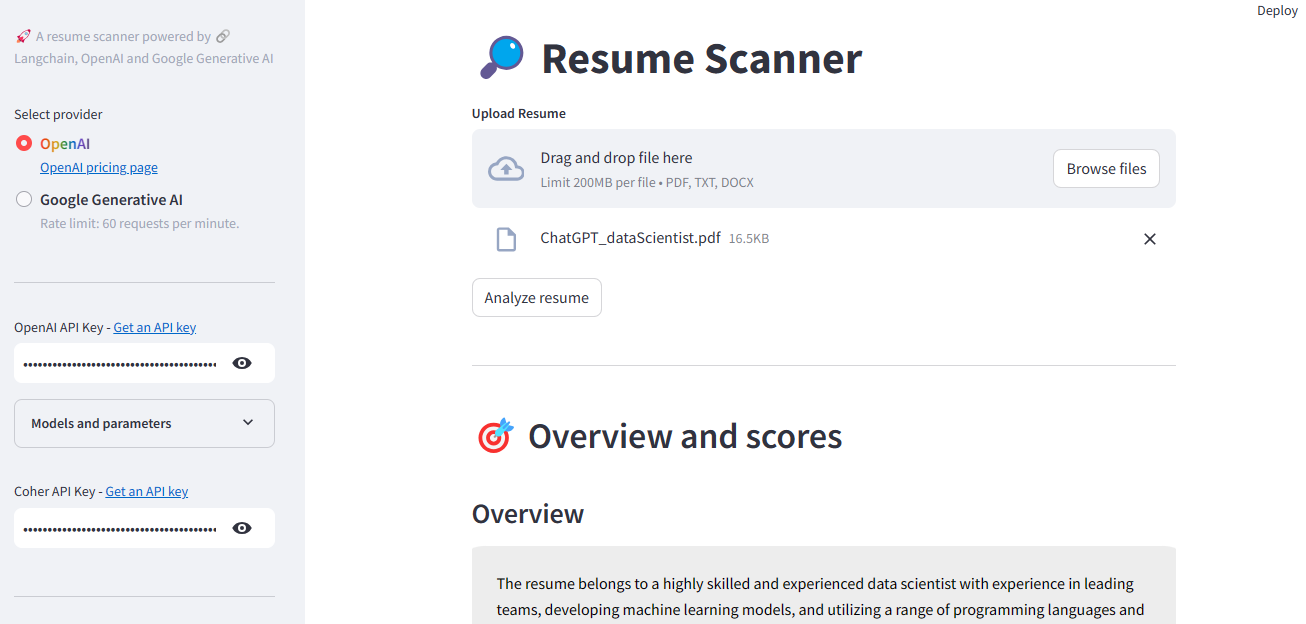

In [61]:
Image.open("./data/screen_Shots/app.png")

- On the sidebar, you can select the LLM provider, a model, and adjust its parameters. Additionally, you can choose the assistant language.

- To upload your resume in PDF format and analyse it, simply click the 'Analyze resume' button on the main panel. The scanned resume will then be displayed section by section, along with an assessment and improved version of each section.

## <a class="anchor" id="conclusion">Conclusion</a>

In this project, we created a CV improver application in Streamlit powered by OpenAI and Google AI APIs.
We used Langchain to create a retrieval system that includes a document loader and a CohereRerank retriever. We also utilized its built-in functions to create prompt templates and interact with the LLM.

To guide the LLM to the desired output, we leveraged prompt engineering best practices by providing clear and specific instructions, outlining the steps to complete a task, and formatting the output as a JSON structured object.

Finally, it is important to note that while LLMs are powerful, no application can accurately determine your accomplishments. AI applications can provide recommendations, but you should only report your actual achievements.
